# Training a Classifier

__1. Loading & normalizing__

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform=transforms.Compose([transforms.ToTensor(), # PILImage image -> tensors
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) #tensors of range [0,1] -> [-1,1]
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


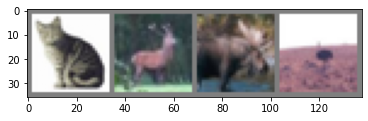

  cat  deer  deer  bird


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2+0.5 #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter=iter(trainloader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

__2. Define a CNN__

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()

__3. Loss function & optimizer__

In [ ]:
import torch.optim as optim
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

__4. Train__

In [ ]:
for epoch in range(2):
    running_loss=0.0
    for i,data in enumerate(trainloader):
        inputs,labels=data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if i%2000==1999: #print statistics every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0

[1,  2000] loss: 2.175
[1,  4000] loss: 1.849
[1,  6000] loss: 1.675
[1,  8000] loss: 1.593
[1, 10000] loss: 1.528
[1, 12000] loss: 1.472
[2,  2000] loss: 1.412
[2,  4000] loss: 1.397
[2,  6000] loss: 1.351
[2,  8000] loss: 1.347
[2, 10000] loss: 1.317
[2, 12000] loss: 1.280


In [ ]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    if var_name=='state':
        continue
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [ ]:
PATH='./drive/MyDrive/Colab Notebooks/PyTorch Tutorial/cifar_net.pth'
torch.save(net.state_dict(),PATH)

__5. Test__

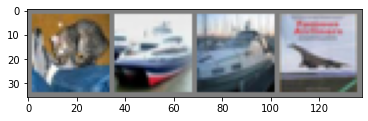

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [ ]:
dataiter=iter(testloader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(4)))

net=Net()
net.load_state_dict(torch.load(PATH))
outputs=net(images)
_,predicted=torch.max(outputs,1)
print('Predicted: ',' '.join('%5s'%classes[predicted[j]] for j in range(4)))

In [ ]:
correct=total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10K test images:',100*correct/total,'%')


Accuracy of the network on the 10K test images: 56.04 %


In [ ]:
class_correct=[0]*10
class_total=[0]*10
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
for i in range(10):
    print(f'Accuracy of {classes[i]:>5}: {100*class_correct[i]/class_total[i]:2}%')

Accuracy of plane: 46.7%
Accuracy of   car: 74.0%
Accuracy of  bird: 32.4%
Accuracy of   cat: 26.7%
Accuracy of  deer: 51.9%
Accuracy of   dog: 59.2%
Accuracy of  frog: 77.3%
Accuracy of horse: 49.2%
Accuracy of  ship: 77.6%
Accuracy of truck: 65.4%


__+. Training on GPU__

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net.to(device) #convert the parameters and buffers to CUDA tensors

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
inputs,labels=data[0].to(device),data[1].to(device)